# LV-Network Design Example 1

Network topology: see `LV_design_01.pdf`

In [1]:
from python_electric import (
    Q_,
    LoadInput,
    GridInput,
    TransformerInput,
    BusBarInput,
    CableInput,
    NetworkTopology,
    EarthingSystem,
    CircuitBreaker,
    Cable,
    BusBar,
    PEConductorConfig
)

## Step 1: Create Loads and Network Topology

In [2]:
network = NetworkTopology(name="LV-network", U_lv = Q_(400, 'V'))

# IMPORTANT - SOURCE CONNECTION: DON'T FORGET TO ADD THIS FIRST!
network.add_connection(
    "C0",
    end_id="MV_BUS",
    load_data=None
)

network.add_connection(
    "C1",
    start_id="MV_BUS",
    end_id="MAIN",  # main distribution board
    load_data=LoadInput(cos_phi=0.9, P_e=Q_(325.76, 'kW'))
)
network.add_connection(
    "C2",
    start_id="MAIN",
    end_id="SUB1",  # sub-distribution board
    load_data=LoadInput(cos_phi=0.7, P_e=Q_(108.83, 'kW'))
)
network.add_connection(
    "C3",
    start_id="SUB1",
    end_id="MOTOR",
    load_data=LoadInput(cos_phi=0.81, P_m=Q_(15, 'kW'), eta=Q_(84, 'pct'))
)

## Step 2: Add Components to Network Connections

### MV-Grid (C0)

In [3]:
grid_dat = GridInput(
    name="grid",
    U_l=Q_(11, 'kV'),
    S_sc=Q_(500, 'MVA'),
    z0_r_factor=0.0,
    z0_x_factor=0.0
)
network.add_component("C0", grid_dat)

### Transformer (C1)

A transformer must already have been selected.

In [4]:
transformer_dat = TransformerInput(
    name="transformer",
    S_n=Q_(630, 'kVA'),
    U_lp=grid_dat.U_l,
    U_ls=network.U_lv,
    u_cc=Q_(4, 'pct'),
    P_Cu=Q_(4600, 'W'),
    pri_conn=TransformerInput.WindingConn.D,
    sec_conn=TransformerInput.WindingConn.YN,
    z0_r_factor=1.0,
    z0_x_factor=0.8
)
network.add_component("C1", transformer_dat)

### Bus Bar (C1)

The dimensions of the bus bars should already have been determined.

In [5]:
busbar_dat = BusBarInput(
    name="busbar",
    S=Q_(499, 'mm**2'),
    I_z=Q_(1142, 'A'),
    L=Q_(4, 'm'),
    z0_r_factor=3.0,
    z0_x_factor=4.0
)
network.add_component("C1", busbar_dat)

### Cable W1 (C2)

Cables are sized when added to the network.

In [6]:
cable_W1_dat = CableInput(
    name="cable_W1",
    L=Q_(37, 'm'),
    k_simul=0.8,
    k_ext=1.2,
    T_amb=Q_(35, 'degC'),
    num_other_circuits=4,
    z0_r_factor=4.3,
    z0_x_factor=2.0,
    earthing_system=EarthingSystem.TN_C
)
network.add_component("C2", cable_W1_dat)

In [7]:
cable_W1: Cable = network.get_component("cable_W1")
print(
    f"Conductor cross-sectional area: {cable_W1.S.to('mm**2'):~P.0f}",
    f"Conductor load current: {cable_W1.I_b_ph.to('A'):~P.0f}",
    f"Conductor nominal current: {cable_W1.I_n.to('A'):~P.0f}",
    f"Conductor ampacity: {cable_W1.I_z.to('A'):~P.0f}",
    f"Conductor ampacity at standard conditions: {cable_W1.I_z0.to('A'):~P.0f}",
    sep="\n"
)

Conductor cross-sectional area: 120 mm²
Conductor load current: 224 A
Conductor nominal current: 250 A
Conductor ampacity: 249 A
Conductor ampacity at standard conditions: 346 A


Total correction factor $k$

In [8]:
k = cable_W1.I_z / cable_W1.I_z0
I_b0 = cable_W1.I_b_ph / k
I_n0 = cable_W1.I_n / k
print(
    f"Total correction factor: {k:.3f}",
    f"Actual load current transformed to standard conditions: {I_b0.to('A'):~P.0f}",
    f"Nominal current transformed to standard conditions: {I_n0.to('A'):~P.0f}",
    sep="\n"
)

Total correction factor: 0.720 dimensionless
Actual load current transformed to standard conditions: 312 A
Nominal current transformed to standard conditions: 347 A


### Cable W2 (C3)

In [9]:
cable_W2_dat = CableInput(
    name="cable_W2",
    L=Q_(31, 'm'),
    num_other_circuits=4,
    z0_r_factor=3.0,
    z0_x_factor=4.0,
    earthing_system=EarthingSystem.TN_S
)
network.add_component("C3", cable_W2_dat)

In [10]:
cable_W2: Cable = network.get_component("cable_W2")
print(
    f"Conductor cross-sectional area: {cable_W2.S.to('mm**2'):~P.0f}",
    f"Conductor load current: {cable_W2.I_b_ph.to('A'):~P.0f}",
    f"Conductor nominal current: {cable_W2.I_n.to('A'):~P.0f}",
    f"Conductor ampacity: {cable_W2.I_z.to('A'):~P.0f}",
    f"Conductor ampacity at standard conditions: {cable_W2.I_z0.to('A'):~P.0f}",
    sep="\n"
)

Conductor cross-sectional area: 6 mm²
Conductor load current: 32 A
Conductor nominal current: 32 A
Conductor ampacity: 40 A
Conductor ampacity at standard conditions: 54 A


## Step 3: Voltage Drop Calculations

Find the voltage drop at the motor terminals (bus 'MOTOR').

### Steady-State Operation (= Design Mode)

In [11]:
dU_motor, dU_rel_motor = network.get_voltage_drop_at_bus('MOTOR')

print(
    f"Absolute voltage drop: {dU_motor.to('V'):~P.2f}",
    f"Relative voltage drop: {dU_rel_motor.to('pct'):~P.2f}",
    sep="\n"
)

Absolute voltage drop: 8.07 V
Relative voltage drop: 3.50 %


Determine the line-to-line voltage at the motor terminals. Note that all voltage drops are calculated with reference to ground.

In [12]:
import math

U_ph_transformer = Q_(420, 'V') / math.sqrt(3)  # no-load voltage of the transformer
U_ph_motor = U_ph_transformer - dU_motor
U_l_motor = math.sqrt(3) * U_ph_motor

print(f"Line voltage at motor terminals: {U_l_motor.to('V'):~P.2f}")

Line voltage at motor terminals: 406.02 V


### Motor Start-Up

When starting, the load current drawn by the motor is 6 times the nominal current of the motor and its power factor is 0.45. The voltage drop calculation at start-up conditions of the motor has to be done "manually" outside the `network` object.

First, we need to determine the load current at steady-state operation drawn by the other consumers that are also connected to sub-distribution board 'SUB1'.

In [13]:
from python_electric import calc

load_sub1 = network.get_load("C2")
load_motor = network.get_load("C3")

cI_sub1 = calc.phasor_from_cos(
    magnitude=load_sub1.I_b.to('A').m,
    cos_phi=load_sub1.cos_phi
)

cI_motor = calc.phasor_from_cos(
    magnitude=load_motor.I_b.to('A').m,
    cos_phi=load_motor.cos_phi
)

cI_other = cI_sub1 - cI_motor
I_other = abs(cI_other)
cos_phi_other = calc.cosphi(cI_other)

print(f"Total current to SUB1: {load_sub1.I_b.to('A'):~P.2f}, cos_phi = {load_sub1.cos_phi:.2f}")
print(f"Motor current: {load_motor.I_b.to('A'):~P.2f}, cos_phi = {load_motor.cos_phi:.2f}")
print(f"Other current: {I_other:.2f} A, cos_phi = {cos_phi_other:.2f}")

Total current to SUB1: 224.40 A, cos_phi = 0.70
Motor current: 31.82 A, cos_phi = 0.81
Other current: 193.11 A, cos_phi = 0.68


Now, we can determine the motor current and the load current that flows to sub-distribution board 'SUB1' when the motor starts.

In [14]:
I_motor_start = 6 * abs(cI_motor)
cos_phi_motor_start = 0.45
cI_motor_start = calc.phasor_from_cos(I_motor_start, cos_phi_motor_start)

cI_sub1_start = cI_other + cI_motor_start
I_sub1_start = abs(cI_sub1_start)
cos_phi_sub1_start = calc.cosphi(cI_sub1_start)

print(f"Motor start current: {I_motor_start:.2f} A, cos_phi = {cos_phi_motor_start:.2f}")
print(f"Total current (A) to SUB1: {I_sub1_start:.2f} A, cos_phi = {cos_phi_sub1_start:.2f}")

Motor start current: 190.92 A, cos_phi = 0.45
Total current (A) to SUB1: 380.25 A, cos_phi = 0.57


With the motor start current and load current to sub-distribution board 'SUB1' determined, the voltage drop across cable W1 (connection C2) and cable W2 (connection C3) can now be calculated directly on the `Cable` objects:

In [15]:
dU_c2_start, dU_rel_c2_start = cable_W1.get_voltage_drop(
    U_l=cable_W1.U_l,
    I_b=Q_(I_sub1_start, 'A'),
    cos_phi=cos_phi_sub1_start
)

dU_c3_start, dU_rel_c3_start = cable_W2.get_voltage_drop(
    U_l=cable_W2.U_l,
    I_b=Q_(I_motor_start, 'A'),
    cos_phi=cos_phi_motor_start
)

dU_c1, dU_rel_c1 = network.get_voltage_drop_of_conn("C1")

dU_tot_start = dU_c1 + dU_c2_start + dU_c3_start
dU_rel_tot_start = dU_rel_c1 + dU_rel_c2_start + dU_rel_c3_start

print(f"Absolute voltage drop cable W1 (C2): {dU_c2_start:~P.2f}")
print(f"Relative voltage drop cable W1 (C2): {dU_rel_c2_start.to('pct'):~P.2f}", "\n")

print(f"Absolute voltage drop cable W2 (C3): {dU_c3_start:~P.2f}")
print(f"Relative voltage drop cable W2 (C3): {dU_rel_c3_start.to('pct'):~P.2f}", "\n")

print(f"Absolute total voltage drop: {dU_tot_start.to('V'):~P.2f}")
print(f"Relative total voltage drop: {dU_rel_tot_start.to('pct'):~P.2f}")

Absolute voltage drop cable W1 (C2): 2.44 V
Relative voltage drop cable W1 (C2): 1.06 % 

Absolute voltage drop cable W2 (C3): 10.48 V
Relative voltage drop cable W2 (C3): 4.54 % 

Absolute total voltage drop: 16.36 V
Relative total voltage drop: 7.08 %


The line voltage at the motor terminals during start-up is now determined as:

In [16]:
U_ph_main = U_ph_transformer - dU_c1
U_ph_motor_start =  U_ph_main - dU_c2_start - dU_c3_start
U_l_motor_start = math.sqrt(3) * U_ph_motor_start

print(f"Line voltage at motor terminals: {U_l_motor_start.to('V'):~P.2f}")

Line voltage at motor terminals: 391.66 V


## Step 4: Short-Circuit Calculations

Once the network topology has been configured and all network components have been added, maximum and minimum short-circuit currents at the network busses can be calculated. It is assumed that the maximum short-circuit current is caused by a bolted three-phase fault at the bus, and that the minimum short-circuit current is caused by a bolted line-to-ground fault at the bus.

In [17]:
sc_results = network.run_shortcircuit_calc()

for bus_id, sc_result in sc_results.items():
    print(
        f"Bus {bus_id}: "
        f"MAX = {sc_result.max.to('kA'):~P.2f}, "
        f"MIN = {sc_result.min.to('kA'):~P.2f}."
    )

Bus MV_BUS: MAX = 26.24 kA, MIN = 39.36 kA.
Bus MAIN: MAX = 22.41 kA, MIN = 22.32 kA.
Bus SUB1: MAX = 15.87 kA, MIN = 9.27 kA.
Bus MOTOR: MAX = 2.52 kA, MIN = 0.87 kA.


## Step 5: Sizing PE-Conductors

The PE-conductor belonging to a cable between two network busses, is sized based on the minimum short-circuit current calculated at the downstream bus.

Global configuration settings for sizing the PE-conductors:

In [18]:
print(network.glob_pe_config)

cond_mat: copper
insul_mat: PVC
mech_protected: False
separated: False
t_interrupt: 200 ms


In [19]:
network.size_all_pe_conductors()

for cable in network.iter_all_cables():
    print(f"{cable.name}: {cable.S:~P.0f}, PE = {cable.S_pe:~P.0f}")

cable_W1: 120 mm², PE = 70 mm²
cable_W2: 6 mm², PE = 6 mm²


> If in a TN-C network a PE-conductor also serves as the neutral conductor of a cable (PEN-conductor), the cross-sectional area of this conductor is determined based on the requirements that apply to the neutral conductor. This is here the case for cable W1.

Individual PE-conductors can still be modified:

In [20]:
S_pe_w1 = network.size_pe_conductor(
    "cable_W1",
    pe_conductor_cfg=PEConductorConfig(
        mech_protected=False,
        separated=True
    )
)
print(S_pe_w1.to('mm**2'))
print(cable_W1.S_pe.to('mm**2'))

35 millimeter ** 2
70 millimeter ** 2


> When the PE-conductor is in the same cable as the other conductors (i.e. not separated), it is assumed that the cross-sectional area of the PE-conductor is equal to the cross-sectional area of the other cable conductors.

## Step 6: Adding Circuit Breakers

### Bus Bar

**Currents**

In [21]:
busbar: BusBar = network.get_component("busbar")
print(
    f"load current: {busbar.I_b.to('A'):~P.1f}",
    f"nominal current: {busbar.I_n.to('A'):~P.1f}",
    f"ampacity: {busbar.I_z.to('A'):~P.1f}",
    f"maximum short-circuit current: {busbar.I_sc_max.to('A'):~P.1f}",
    f"minimum short-circuit current: {busbar.I_sc_min.to('A'):~P.1f}",
    sep="\n"
)

load current: 522.4 A
nominal current: 1000.0 A
ampacity: 1142.0 A
maximum short-circuit current: 26243.2 A
minimum short-circuit current: 22320.0 A


**Circuit Breaker Suggestion**

In [22]:
cb_bb_sug = network.suggest_circuit_breaker(
    "busbar",
    prefer_adjustable=True
)
print(cb_bb_sug)

standard: IEC 60947-2
category: adjustable
I_cu: 36 kA
k_m: 14.0


> Whether an adjustable circuit is preferred, will depend on the nominal current of the cable or bus bar. If the nominal current is high, an adjustable circuit breaker will probably be preferred.

**Circuit Breaker Selection**

In [23]:
cb_bb = network.connect_circuit_breaker(
    "busbar",
    standard=CircuitBreaker.Standard.INDUSTRIAL,
    category=cb_bb_sug.category,
    I_cu=cb_bb_sug.I_cu,
    k_m=cb_bb_sug.k_m
)
print(cb_bb)

I_n     = 1000.0 A
I_r     = 522.4 A
I_nf    = 548.6 A
I_f     = 679.2 A
t_conv  = 2.0 h
I_m_min = 5851.3 A
I_m_max = 8777.0 A
t_m_lim = 100.0 ms


### Cable W1

**Currents**

In [24]:
print(
    f"load current: {cable_W1.I_b_ph.to('A'):~P.1f}",
    f"nominal current: {cable_W1.I_n.to('A'):~P.1f}",
    f"ampacity: {cable_W1.I_z.to('A'):~P.1f}",
    f"maximum short-circuit current: {cable_W1.I_sc_max.to('A'):~P.1f}",
    f"minimum short-circuit current: {cable_W1.I_sc_min.to('A'):~P.1f}",
    sep="\n"
)

load current: 224.4 A
nominal current: 250.0 A
ampacity: 249.1 A
maximum short-circuit current: 22405.8 A
minimum short-circuit current: 9273.0 A


**Circuit Breaker Suggestion**

In [25]:
cb_w1_sug = network.suggest_circuit_breaker(
    cable_id="cable_W1",
    safety_factor_Icu=2.0,
    prefer_adjustable=True
)
print(cb_w1_sug)

standard: IEC 60947-2
category: adjustable
I_cu: 50 kA
k_m: 14.0


**Circuit Breaker Selection**

In [26]:
cb_w1 = network.connect_circuit_breaker(
    "cable_W1",
    standard=CircuitBreaker.Standard.INDUSTRIAL,
    category=cb_w1_sug.category,
    I_cu=cb_w1_sug.I_cu,
    k_m=cb_w1_sug.k_m
)
print(cb_w1)

I_n     = 250.0 A
I_r     = 224.4 A
I_nf    = 235.6 A
I_f     = 291.7 A
t_conv  = 2.0 h
I_m_min = 2513.3 A
I_m_max = 3770.0 A
t_m_lim = 100.0 ms


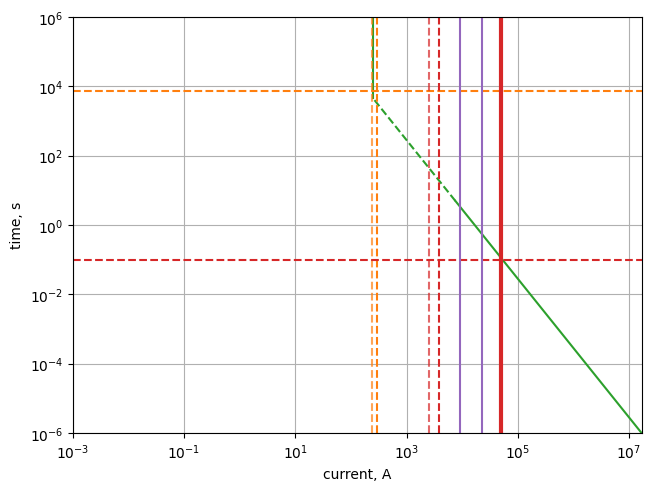

In [27]:
plt_w1 = network.plot_cable("cable_W1")
plt_w1.show()

A cable plot shows a simplified version of the cable characteristic (green lines), together with the required main characteristics of the circuit breaker that must protect the cable (from left to right and from top to bottom: conventional non-tripping current $I_{nf}$, conventional tripping current $I_f$, conventional time, minimum short-circuit tripping current, maximum short-circuit tripping current, magnetic tripping-time limit, ultimate breaking capacity). The plot also indicates the calculated minimum and maximum short-circuit current through the cable.

- the circuit breaker must certainly trip within the conventional time, when the current through the cable exceeds $I_f$.
- the circuit breaker must certainly trip before the magnetic tripping-time limit is reached, when the current through the cable exceeds the maximum short-circuit tripping current.

From the cable plot it can be seen that:
- both the minimum and maximum short-circuit current are behind the maximum short-circuit tripping current, so they are certainly interrupted before the magnetic tripping-time limit is reached.
- the ultimate breaking capacity of the circuit-breaker is greater than the calculated maximum short-ciruit current.
- the intersection between the cable characteristic and the minimum short-circuit current lies above the magnetic tripping-time limit, so the Joule-integral of the cable won't be exceeded during the time the minimum short-circuit is allowed to flow.
- the same also applies to the maximum short-circuit current.

### Cable W2

**Currents**

In [28]:
print(
    f"load current: {cable_W2.I_b_ph.to('A'):~P.1f}",
    f"nominal current: {cable_W2.I_n.to('A'):~P.1f}",
    f"ampacity: {cable_W2.I_z.to('A'):~P.1f}",
    f"maximum short-circuit current: {cable_W2.I_sc_max.to('A'):~P.1f}",
    f"minimum short-circuit current: {cable_W2.I_sc_min.to('A'):~P.1f}",
    sep="\n"
)

load current: 31.8 A
nominal current: 32.0 A
ampacity: 40.5 A
maximum short-circuit current: 15872.4 A
minimum short-circuit current: 873.9 A


**Circuit Breaker Suggestion**

In [29]:
cb_w2_sug = network.suggest_circuit_breaker(
    cable_id="cable_W2",
    safety_factor_Icu=2.0,
    prefer_adjustable=False
)
print(cb_w2_sug)

standard: IEC 60947-2
category: C
I_cu: 36 kA
k_m: None

Warnings:
---------
Let-through energy (2.5193×10⁷ A²·s) > Joule-integral of the cable (7.1200×10⁵ A²·s).


**Circuit Breaker Selection**

As the load is an induction motor, we opt for category D instead of C. We've also found a circuit breaker of category D of which the let-through energy at `I_sc_max` is smaller than the Joule-integral of the cable.

In [30]:
cb_w2 = network.connect_circuit_breaker(
    "cable_W2",
    standard=CircuitBreaker.Standard.INDUSTRIAL,
    category=CircuitBreaker.Category.D,
    I_cu=cb_w2_sug.I_cu,
    E_t=Q_(5e5, 'A ** 2 * s')
)
print(cb_w2)

I_n     = 32.0 A
I_r     = 32.0 A
I_nf    = 33.6 A
I_f     = 41.6 A
t_conv  = 1.0 h
I_m_min = 307.2 A
I_m_max = 460.8 A
t_m_lim = 100.0 ms


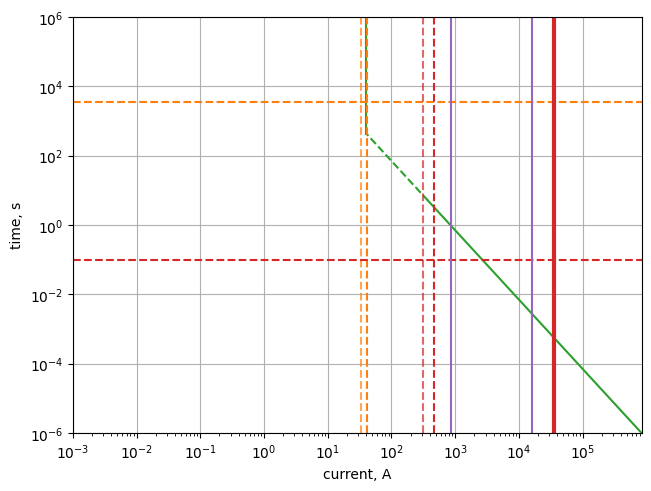

In [31]:
plt_w2 = network.plot_cable("cable_W2")
plt_w2.show()

From the cable plot, it is seen that the intersection of the maximum short-circuit current and the cable characteristic (green curve) lies below the maximum tripping-time limit. However, as the specified thermal energy `E_t` let through by the circuit breaker during the interruption of the maximum short-circuit current is less than the Joule-integral of the cable, no warning is given. Should we raise `E_t` beyond the Joule-integral of the cable a `ProtectionWarning` would be given. If `E_t` is not specified (None), `E_t` is simply calculated (estimated) as the product of the square of the maximum short-circuit current and the magnetic tripping-time limit.

### Check Selectivity Between CB of Upstream Cable W1 and CB of Downstream Cable W2

In [32]:
res = network.check_selectivity(up_id="cable_W1", down_id="cable_W2")
print(res)

selectivity exists: True
total selectivity: True
maximum allowable tripping-time upstream circuit breaker: 187 ms
available tripping-delay: 87 ms


Following rules are applied to evaluate selectivity between an upstream and downstream circuit breaker.

*Current selectivity* is assumed to exist if:
- the conventional tripping current of the downstream circuit breaker is smaller than the conventional non-tripping current of the upstream circuit breaker, AND,
- the maximum short-circuit tripping current of the downstream circuit breaker is smaller than the minimum short-circuit tripping current of the upstream circuit breaker.

*Total selectivity* is assumed to be obtainable if:
- current selectivity exists, AND
- the maximum short-circuit current in the downstream cable is smaller than the minimum short-circuit tripping current of the upstream circuit breaker.

However, in case of industrial circuit-breakers with an adjustable time-delay, total selectivity may be reached by delaying the interruption of the upstream circuit breaker. The maximum allowable tripping-time of the upstream circuit breaker is determined based on the joule-integral of the upstream cable, and also the maximum allowable fault duration to ensure the protection against indirect contact.

## Step 7: Check Protection against Indirect Contact

In [33]:
results = network.check_final_circuits()
for k, r in results.items():
    print(f"Final ciruit '{k}':", r, sep="\n")

Final ciruit 'cable_W2':
	passed: True
	fault current: 803.6 A
	fault voltage: 92.4 V
	maximum allowable fault duration: 200 ms
	maximum allowable cable length: 54 m
	maximum allowable resistance of the PE-conductor(s): 200 mΩ


> 1. If the interruption time of the circuit breaker for the given fault current is less than the maximum allowable fault (or contact) duration, we can conclude that the protection against indirect contact is satisfied.
> 2. If the actual cable length of the circuit is less than the maximum allowable cable length, we can conclude that the protection against indirect contact is satisfied.
> 3. The maximum allowable resistance of the PE-conductor(s) applies to the total length between the main earthing terminal and the exposed conductive part farthest in the final circuit.